In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("darkgrid")

import common_functions as cf

In [28]:
cf.SEQUENCE_SIZE

100

## Import Data

In [29]:
df_all = pd.read_pickle("merged_w_df.pkl")

In [30]:
df_all.shape

(114700, 15)

In [31]:
df_all.head(2)

,rotR_x,rotR_y,rotR_z,acc_x,acc_y,acc_z,or_x,or_y,or_z,grav_x,grav_y,grav_z,action,label,action_num
0,-12.012195,5.243902,1.158537,0.098145,0.047607,0.029785,15,13,80,0.271240,-0.230225,0.934326,t_stand_left_DrinkBottle_10ml_1s_right,1,0
1,-23.780488,17.195122,3.658537,0.093994,0.043213,0.041748,15,14,80,0.259766,-0.249023,0.932861,t_stand_left_DrinkBottle_10ml_1s_right,1,0


# Feature engineering (basic)

In [32]:
df_fe = cf.fe_basic_features(df_all)
#df_fe = df_all.copy()

In [33]:
df_fe.head(2)

,accel_norm,rotR_x,rotR_y,rotR_z,acc_x,acc_y,acc_z,or_x,or_y,or_z,grav_x,grav_y,grav_z,action,label,action_num
0,1.048477,-12.012195,5.243902,1.158537,0.098145,0.047607,0.029785,15,13,80,0.271240,-0.230225,0.934326,t_stand_left_DrinkBottle_10ml_1s_right,1,0
1,1.057056,-23.780488,17.195122,3.658537,0.093994,0.043213,0.041748,15,14,80,0.259766,-0.249023,0.932861,t_stand_left_DrinkBottle_10ml_1s_right,1,0


In [34]:
df_fe.shape

(114700, 16)

## Data Splitting(Test/train)

In [35]:
train_df,test_df = cf.data_split_TrainTest(df_fe)

In [36]:
train_df.shape,test_df.shape

((63000, 16), (51700, 16))

## Preprocess (Normalizing)

In [37]:
from sklearn.preprocessing import StandardScaler
last_feat_column = df_fe.columns[-4]

for act_num in train_df.action_num.unique():
    std = StandardScaler().set_output(transform='pandas')
    
    train_df_w_act_num = train_df.loc[train_df.action_num == act_num,:last_feat_column].copy()
    std.fit(train_df_w_act_num)
    train_df.loc[train_df.action_num == act_num,:last_feat_column] = std.transform(train_df_w_act_num)


for act_num in test_df.action_num.unique():
    std = StandardScaler().set_output(transform='pandas')
    
    test_df_w_act_num = test_df.loc[test_df.action_num == act_num,:last_feat_column].copy()
    std.fit(test_df_w_act_num)
    test_df.loc[test_df.action_num == act_num,:last_feat_column] = std.transform(test_df_w_act_num)

In [38]:
train_df.shape,test_df.shape

((63000, 16), (51700, 16))

## Modeling

### Split Data (Feature/Label)

In [39]:
def load_dataset():
    X_train,y_train = cf.data_split_FeatLabel(train_df)
    X_test,y_test = cf.data_split_FeatLabel(test_df)
   
    X_train = np.asarray(X_train).reshape(int(X_train.shape[0]/cf.SEQUENCE_SIZE) , cf.SEQUENCE_SIZE, X_train.shape[1])
    y_train = np.asarray(y_train).reshape(int(y_train.shape[0]/cf.SEQUENCE_SIZE) , cf.SEQUENCE_SIZE)
    y_train_compact=[]
    for lis in y_train:
        if sum(lis) == 0:
            y_train_compact.append(0)
        elif sum(lis) == cf.SEQUENCE_SIZE:
            y_train_compact.append(1)
        else:
            print("something wrong")
    y_train_compact = np.asarray(y_train_compact)
    X_test = np.asarray(X_test).reshape(int(X_test.shape[0]/cf.SEQUENCE_SIZE) , cf.SEQUENCE_SIZE, X_test.shape[1])
    y_test = np.asarray(y_test).reshape(int(y_test.shape[0]/cf.SEQUENCE_SIZE) , cf.SEQUENCE_SIZE)
    y_test_compact=[]
    for lis in y_test:
        if sum(lis) == 0:
            y_test_compact.append(0)
        elif sum(lis) == cf.SEQUENCE_SIZE:
            y_test_compact.append(1)
        else:
            print("something wrong")
    y_test_compact = np.asarray(y_test_compact)

    return  X_train,y_train_compact,X_test,y_test_compact

In [40]:
# load data
trainX, trainy, testX, testy = load_dataset()

In [41]:
trainX.shape,trainy.shape, testX.shape, testy.shape

((630, 100, 13), (630,), (517, 100, 13), (517,))

In [42]:
((1443, 50, 13), (1443,), (1127, 50, 13), (1127,))

((1443, 50, 13), (1443,), (1127, 50, 13), (1127,))

In [43]:
n_features = trainX.shape[2]

# reshape data into time steps of sub-sequences
n_steps = 4
n_length = int(cf.SEQUENCE_SIZE/n_steps) 

trainX_resh = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
testX_resh = testX.reshape((testX.shape[0], n_steps, n_length, n_features))

In [44]:
trainy.shape, testy.shape

((630,), (517,))

In [45]:
trainX_resh.shape,testX_resh.shape

((630, 4, 25, 13), (517, 4, 25, 13))

### Neurel Network

In [46]:
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Flatten,Dropout,LSTM,TimeDistributed,MaxPooling1D,Conv1D,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import tensorflow as tf
import sklearn
tf.random.set_seed(20) # to fix the randomization
np.random.seed(20)# to fix the randomizationin sklearn
sklearn.random.seed(1)

In [47]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=50, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(Conv1D(filters=50, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
#print(model.summary())


In [48]:
opt = Adam(learning_rate=0.005)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

X_train, val_X, y_train, val_y = train_test_split(trainX_resh, trainy, shuffle=True,test_size=0.2 ,random_state=10)

In [49]:
X_train.shape, val_X.shape, y_train.shape, val_y.shape

((504, 4, 25, 13), (126, 4, 25, 13), (504,), (126,))

In [50]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=25)
mc = ModelCheckpoint('best_model_LSTM.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit network
history = model.fit(X_train, y_train, epochs=100, batch_size=int(cf.SEQUENCE_SIZE/2),validation_data=(val_X,val_y),callbacks=[es,mc],verbose=0)


Epoch 1: val_accuracy improved from -inf to 0.76984, saving model to best_model_LSTM.h5

Epoch 2: val_accuracy improved from 0.76984 to 0.81746, saving model to best_model_LSTM.h5

Epoch 3: val_accuracy did not improve from 0.81746

Epoch 4: val_accuracy improved from 0.81746 to 0.88889, saving model to best_model_LSTM.h5

Epoch 5: val_accuracy did not improve from 0.88889

Epoch 6: val_accuracy did not improve from 0.88889

Epoch 7: val_accuracy did not improve from 0.88889

Epoch 8: val_accuracy improved from 0.88889 to 0.90476, saving model to best_model_LSTM.h5

Epoch 9: val_accuracy improved from 0.90476 to 0.92857, saving model to best_model_LSTM.h5

Epoch 10: val_accuracy did not improve from 0.92857

Epoch 11: val_accuracy improved from 0.92857 to 0.93651, saving model to best_model_LSTM.h5

Epoch 12: val_accuracy did not improve from 0.93651

Epoch 13: val_accuracy did not improve from 0.93651

Epoch 14: val_accuracy did not improve from 0.93651

Epoch 15: val_accuracy did no

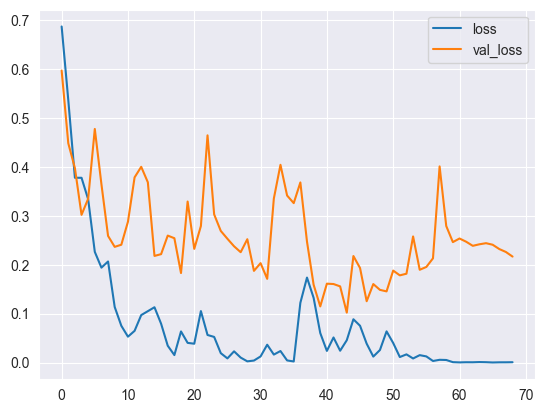

In [51]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss',"val_loss"]].plot()
plt.show()

#### Evaluate

In [52]:
best_saved_model = load_model('best_model_LSTM.h5')
_, train_acc = best_saved_model.evaluate(trainX_resh, trainy, verbose=0)
_, test_acc = best_saved_model.evaluate(testX_resh, testy, verbose=0)
print('Train: %.2f, Test: %.2f' % (train_acc*100, test_acc*100))

Train: 99.52, Test: 92.84
